In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklift.metrics import uplift_at_k, qini_auc_score, weighted_average_uplift
from sklift.viz import plot_uplift_preds, plot_uplift_curve, plot_qini_curve, plot_uplift_by_percentile
from sklift.models import SoloModel, ClassTransformation, TwoModels

from catboost import CatBoostClassifier

In [2]:
df = pd.read_csv('data.csv')
print(df.shape)
df.head(3)

(64000, 9)


,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [3]:
new_vals = []
for val in df['offer'].values:
    if val == 'Buy One Get One' or val == 'Discount':
        new_vals.append(1)
    else:
        new_vals.append(0)

In [4]:
df['treat'] = new_vals
df['target'] = df['conversion'].values
df.drop(['offer', 'conversion'], axis=1, inplace=True)

In [5]:
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treat,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0


In [6]:
treat = df.pop('treat')
target = df.pop('target')

In [7]:
indices_learn, indices_val = train_test_split(df.index, test_size=0.3, random_state=1)

In [8]:
X_train = df.loc[indices_learn, :]
treat_train = treat.loc[indices_learn]
y_train = target.loc[indices_learn]

X_val = df.loc[indices_val, :]
treat_val = treat.loc[indices_val]
y_val = target.loc[indices_val]

cats = ['zip_code', 'channel']

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

## 1 SoloModel

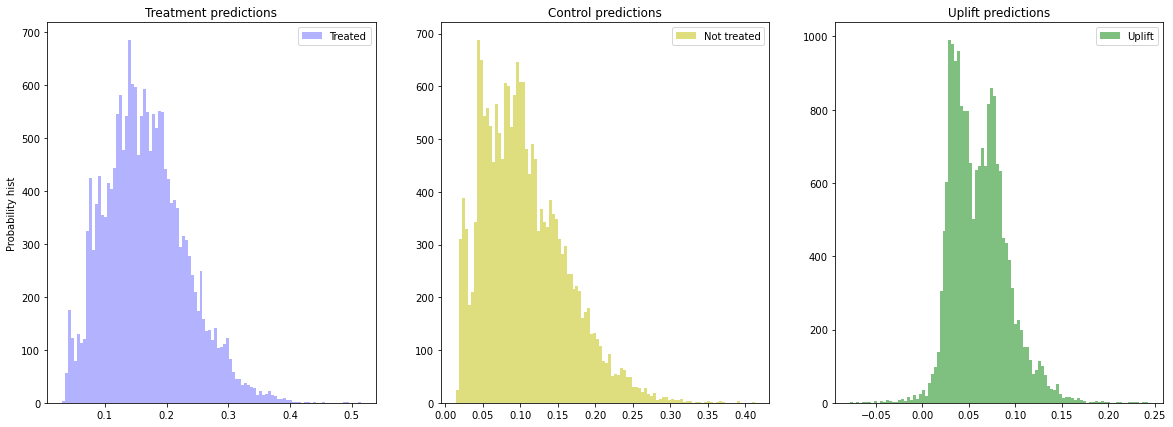

In [9]:
sm = SoloModel(
    CatBoostClassifier(iterations=100, random_state=42, silent=True, cat_features=cats)
)

sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_val)

sm10_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
sm20_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm10_score)
models_results['uplift@20%'].append(sm20_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [10]:
sm10_score

0.09325257419745608

In [11]:
sm20_score

0.09897032101756512

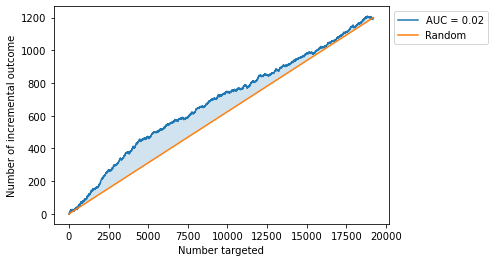

In [12]:
plot_uplift_curve(
    y_val, uplift_sm, treat_val, 
    # perfect=True,
    perfect=False
);

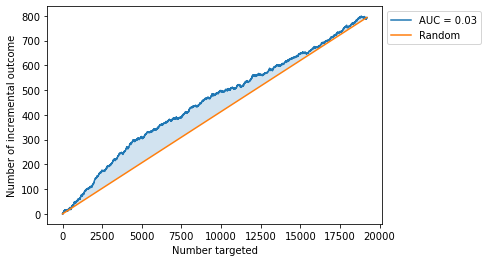

In [13]:
plot_qini_curve(
    y_val, uplift_sm, treat_val,
    # perfect=True
    perfect=False
);

In [14]:
auqc = qini_auc_score(y_val, uplift_sm, treat_val) 
print(f"Qini coefficient on full data: {auqc:.4f}")

Qini coefficient on full data: 0.0344


C:\Users\David\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


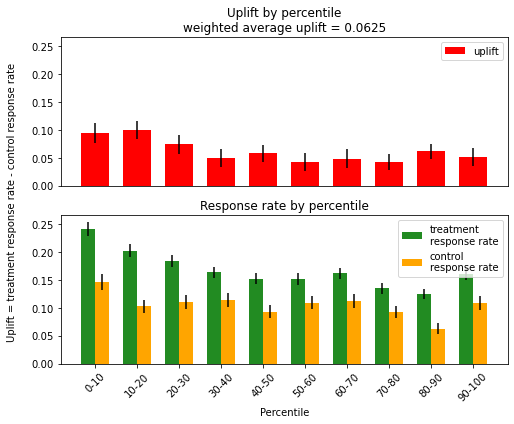

In [15]:
plot_uplift_by_percentile(y_val, uplift_sm, treat_val, 
                          strategy='overall', kind='bar'); # line

In [16]:
uplift_full_data = weighted_average_uplift(y_val, uplift_sm, 
                                            treat_val, bins=10) 
print(f"weighted average uplift on full data: {uplift_full_data:.4f}")

weighted average uplift on full data: 0.0623


## 2 ClassTransformation

In [17]:
ct = ClassTransformation(
    CatBoostClassifier(iterations=100, random_state=42, silent=True, cat_features=cats)
)
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_val)

ct10_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
ct20_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)


models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct10_score)
models_results['uplift@20%'].append(ct20_score)

In [18]:
ct10_score, ct20_score

(0.08566929133858267, 0.06964869775893398)

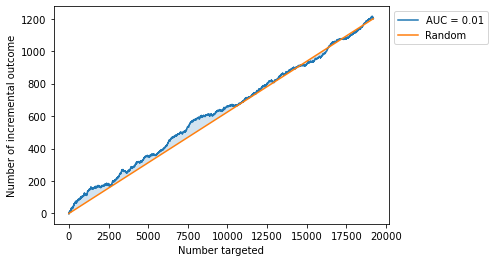

In [19]:
plot_uplift_curve(
    y_val, uplift_ct, treat_val, 
    # perfect=True
    perfect=False
);

C:\Users\David\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


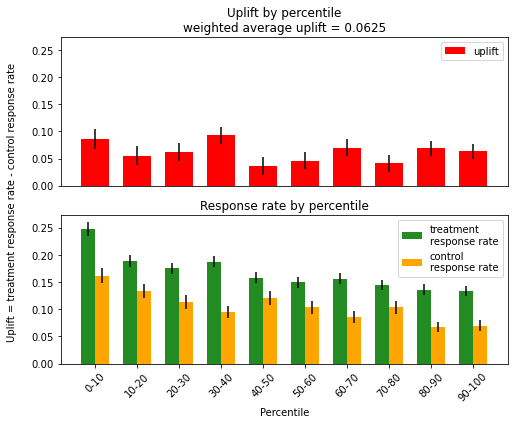

In [20]:
plot_uplift_by_percentile(y_val, uplift_ct, treat_val, 
                          strategy='overall', kind='bar'); # line

## Две независимые модели

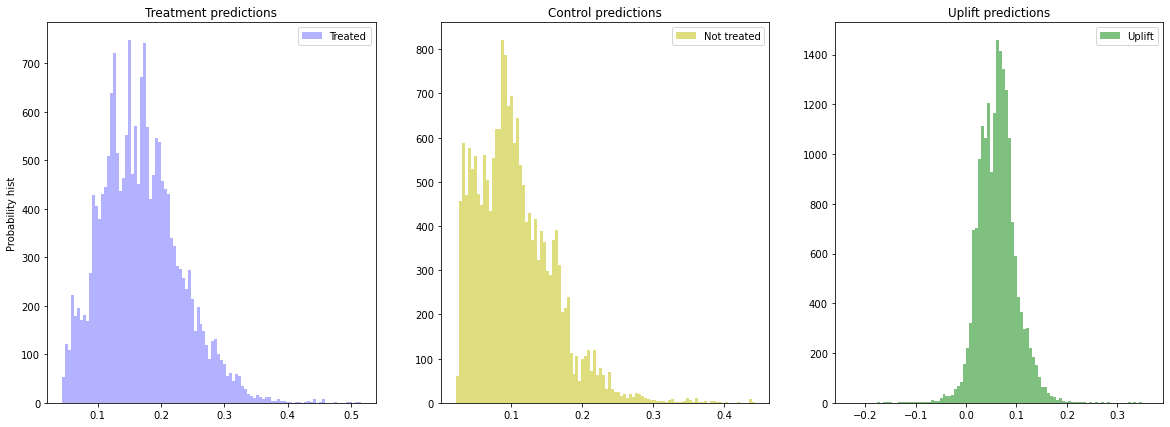

In [21]:
tm = TwoModels(
    CatBoostClassifier(iterations=100, random_state=42, silent=True, cat_features=cats),
    CatBoostClassifier(iterations=100, random_state=42, silent=True, cat_features=cats),
    method='vanilla'  # независимые модели
)
tm = tm.fit(
    X_train, y_train, treat_train
)

uplift_tm = tm.predict(X_val)

tm10_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
tm20_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm10_score)
models_results['uplift@20%'].append(tm20_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [23]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%,uplift@20%
0,SoloModel,0.093253,0.098970
1,ClassTransformation,0.085669,0.069649
2,TwoModels,0.081975,0.086087


In [24]:
pd.DataFrame(data=models_results).sort_values('uplift@20%', ascending=False)

,approach,uplift@10%,uplift@20%
0,SoloModel,0.093253,0.098970
2,TwoModels,0.081975,0.086087
1,ClassTransformation,0.085669,0.069649


Solo Model


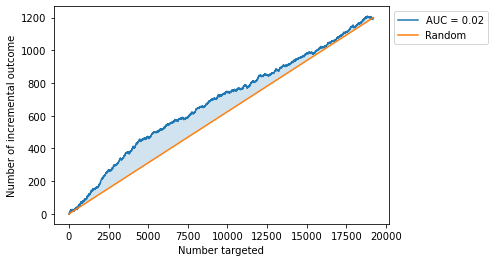

ClassTransform Model


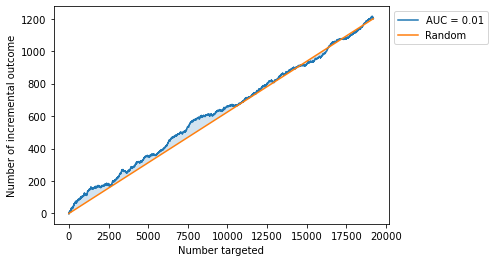

Two Model


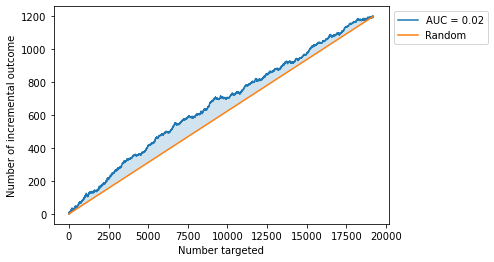

In [25]:
print('Solo Model')
plot_uplift_curve(y_val, uplift_sm, treat_val, perfect=False)
plt.show()
print('ClassTransform Model')
plot_uplift_curve(y_val, uplift_ct, treat_val, perfect=False)
plt.show()
print('Two Model')
plot_uplift_curve(y_val, uplift_tm, treat_val, perfect=False)
plt.show()